# ML accelerated CFD data analysis

This notebook reproduces key figures in our [PNAS paper](https://www.pnas.org/content/118/21/e2101784118) based on saved datasets. The data is stored in netCDF files in Google Cloud Storage, and the analysis uses xarray and JAX-CFD.

> Indented block



In [ ]:
! pip install -U xarray jax-cfd[data]==0.1.0

## Figure 1

Replication of the Figure 1 from the PNAS paper, except with a [bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) based estimation of uncertainty, given the sample size of 16 trajectories.

In [1]:
# @title Utility functions
import xarray
import seaborn
import numpy as np
import pandas as pd
import jax_cfd.data.xarray_utils as xru
from jax_cfd.data import evaluation
import matplotlib.pyplot as plt

C:\Users\William\anaconda3\envs\jax-env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\William\anaconda3\envs\jax-env\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\William\anaconda3\envs\jax-env\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\William\anaconda3\envs\jax-env\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Load data

In [2]:
import os
cwd = os.getcwd()

In [ ]:
%time ! gsutil -m cp -r gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000_fig1 C:\Users\William\Documents\Python\EAEE4000_ML_for_Env_Eng_Sci-main\EAEE4000_ML_for_Env_Eng_Sci-main\Final\content

In [ ]:
! dir %cd%\content\kolmogorov_re_1000_fig1

In [3]:
baseline_filenames = {
    f'baseline_{r}': f'baseline_{r}x{r}.nc'
    for r in [64, 128, 256, 512, 1024, 2048]
}
learned_filenames = {
    f'learned_interp_{r}': f'learned_{r}x{r}.nc'
    for r in [32, 64, 128]
}

models = {}
for k, v in baseline_filenames.items():
  models[k] = xarray.open_dataset(f'{cwd}/content/kolmogorov_re_1000_fig1/{v}', chunks={'time': '100MB'})
for k, v in learned_filenames.items():
  ds = xarray.open_dataset(f'{cwd}/content/kolmogorov_re_1000_fig1/{v}', chunks={'time': '100MB'})
  models[k] = ds.reindex_like(models['baseline_64'], method='nearest')

combined_fig1 = xarray.concat(list(models.values()), dim='model')
combined_fig1.coords['model'] = list(models.keys())
combined_fig1['vorticity'] = xru.vorticity_2d(combined_fig1)

In [4]:
# Notice that the data in Figure 1 was resampled to 32x32 for validation, the
# coarsest resolution of any of the constitutive models.
combined_fig1

<xarray.Dataset>
Dimensions:    (time: 2441, x: 32, y: 32, model: 9, sample: 16)
Coordinates:
  * time       (time) float64 0.0 0.01402 0.02805 0.04207 ... 34.19 34.21 34.22
  * x          (x) float64 0.09817 0.2945 0.4909 0.6872 ... 5.792 5.989 6.185
  * y          (y) float64 0.09817 0.2945 0.4909 0.6872 ... 5.792 5.989 6.185
  * sample     (sample) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * model      (model) <U18 'baseline_64' ... 'learned_interp_128'
Data variables:
    u          (model, sample, time, x, y) float32 dask.array<chunksize=(1, 16, 1525, 32, 32), meta=np.ndarray>
    v          (model, sample, time, x, y) float32 dask.array<chunksize=(1, 16, 1525, 32, 32), meta=np.ndarray>
    vorticity  (model, sample, time, x, y) float64 dask.array<chunksize=(1, 16, 1525, 32, 32), meta=np.ndarray>
Attributes: (12/25)
    domain_size:                   6.283185307179586
    domain_size_multiple:          1
    full_config_str:               import google3.research.simulation.whirl.m...
    init_cfl_safety_factor:        0.5
    init_peak_wavenumber:          4.0
    maximum_velocity:              7.0
    ...                            ...
    time_subsample_factor:         1
    tracing_max_duration_in_msec:  100.0
    warmup_grid_size:              2048
    warmup_time:                   40.0
    xm_experiment_id:              18497215
    xm_work_unit_id:               6

## Figure 2

Here we reproduce the key parts of Figure 2, from scratch.

Note that Figure 2 (and Figure 5) inadvertently used a different evaluation dataset than Figure 1 (different random initial velocity fields), saved at 64x64 resolution.

### Copy data

In [ ]:
%time ! gsutil -m cp gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000/learned*.nc {cwd}\content

In [ ]:
%time ! gsutil -m cp gs://gresearch/jax-cfd/public_eval_datasets/kolmogorov_re_1000/long_eval*.nc {cwd}\content

### Load data at 64x64 and 32x32 resolutions

In [4]:
import xarray
import seaborn
import jax_cfd.data.xarray_utils as xru
from jax_cfd.data import evaluation
import matplotlib.pyplot as plt

baseline_palette = seaborn.color_palette('YlGnBu', n_colors=7)[1:]
models_color = seaborn.xkcd_palette(['burnt orange'])
palette = baseline_palette + models_color


In [5]:
filenames = {
    f'baseline_{r}': f'long_eval_{r}x{r}_64x64.nc'
    for r in [64, 128, 256, 512, 1024, 2048]
}
filenames['learned_interp_64'] = 'learned_interpolation_long_eval_64x64_64x64.nc'

models = {}
for k, v in filenames.items():
  models[k] = xarray.open_dataset(f'{cwd}/content/{v}', chunks={'time': '100MB'})

combined = xarray.concat(list(models.values()), dim='model')
combined.coords['model'] = list(models.keys())
combined['vorticity'] = xru.vorticity_2d(combined)

In [6]:
from jax_cfd.base import resize
import numpy as np
import pandas as pd

def resize_64_to_32(ds):
  coarse = xarray.Dataset({
      'u': ds.u.isel(x=slice(1, None, 2)).coarsen(y=2, coord_func='max').mean(),
      'v': ds.v.isel(y=slice(1, None, 2)).coarsen(x=2, coord_func='max').mean(),
  })
  coarse.attrs = ds.attrs
  return coarse

combined_32 = resize_64_to_32(combined)
combined_32['vorticity'] = xru.vorticity_2d(combined_32)

models_32 = {k: resize_64_to_32(v) for k, v in models.items()}

### Plot solutions: Fig 2(a)

In [8]:
combined_32

<xarray.Dataset>
Dimensions:    (time: 3477, x: 32, y: 32, sample: 16, model: 7)
Coordinates:
  * time       (time) float64 0.0 0.07012 0.1402 0.2104 ... 243.6 243.7 243.8
  * x          (x) float64 0.1473 0.3436 0.54 0.7363 ... 5.645 5.841 6.038 6.234
  * y          (y) float64 0.1473 0.3436 0.54 0.7363 ... 5.645 5.841 6.038 6.234
  * sample     (sample) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * model      (model) <U17 'baseline_64' 'baseline_128' ... 'learned_interp_64'
Data variables:
    u          (model, sample, time, x, y) float32 dask.array<chunksize=(1, 16, 381, 32, 32), meta=np.ndarray>
    v          (model, sample, time, x, y) float32 dask.array<chunksize=(1, 16, 381, 32, 32), meta=np.ndarray>
    vorticity  (model, sample, time, x, y) float64 dask.array<chunksize=(1, 16, 381, 32, 32), meta=np.ndarray>
Attributes: (12/17)
    domain_size:                   [0.         6.28318531]
    domain_size_multiple:          1
    full_config_str:               \n# Macros:\n# ===========================...
    init_cfl_safety_factor:        0.5
    init_peak_wavenumber:          4.0
    maximum_velocity:              7.0
    ...                            ...
    simulation_time:               240.0
    stable_time_step:              0.007012483601762931
    time_subsample_factor:         1
    tracing_max_duration_in_msec:  100.0
    warmup_grid_size:              2048
    warmup_time:                   40.0

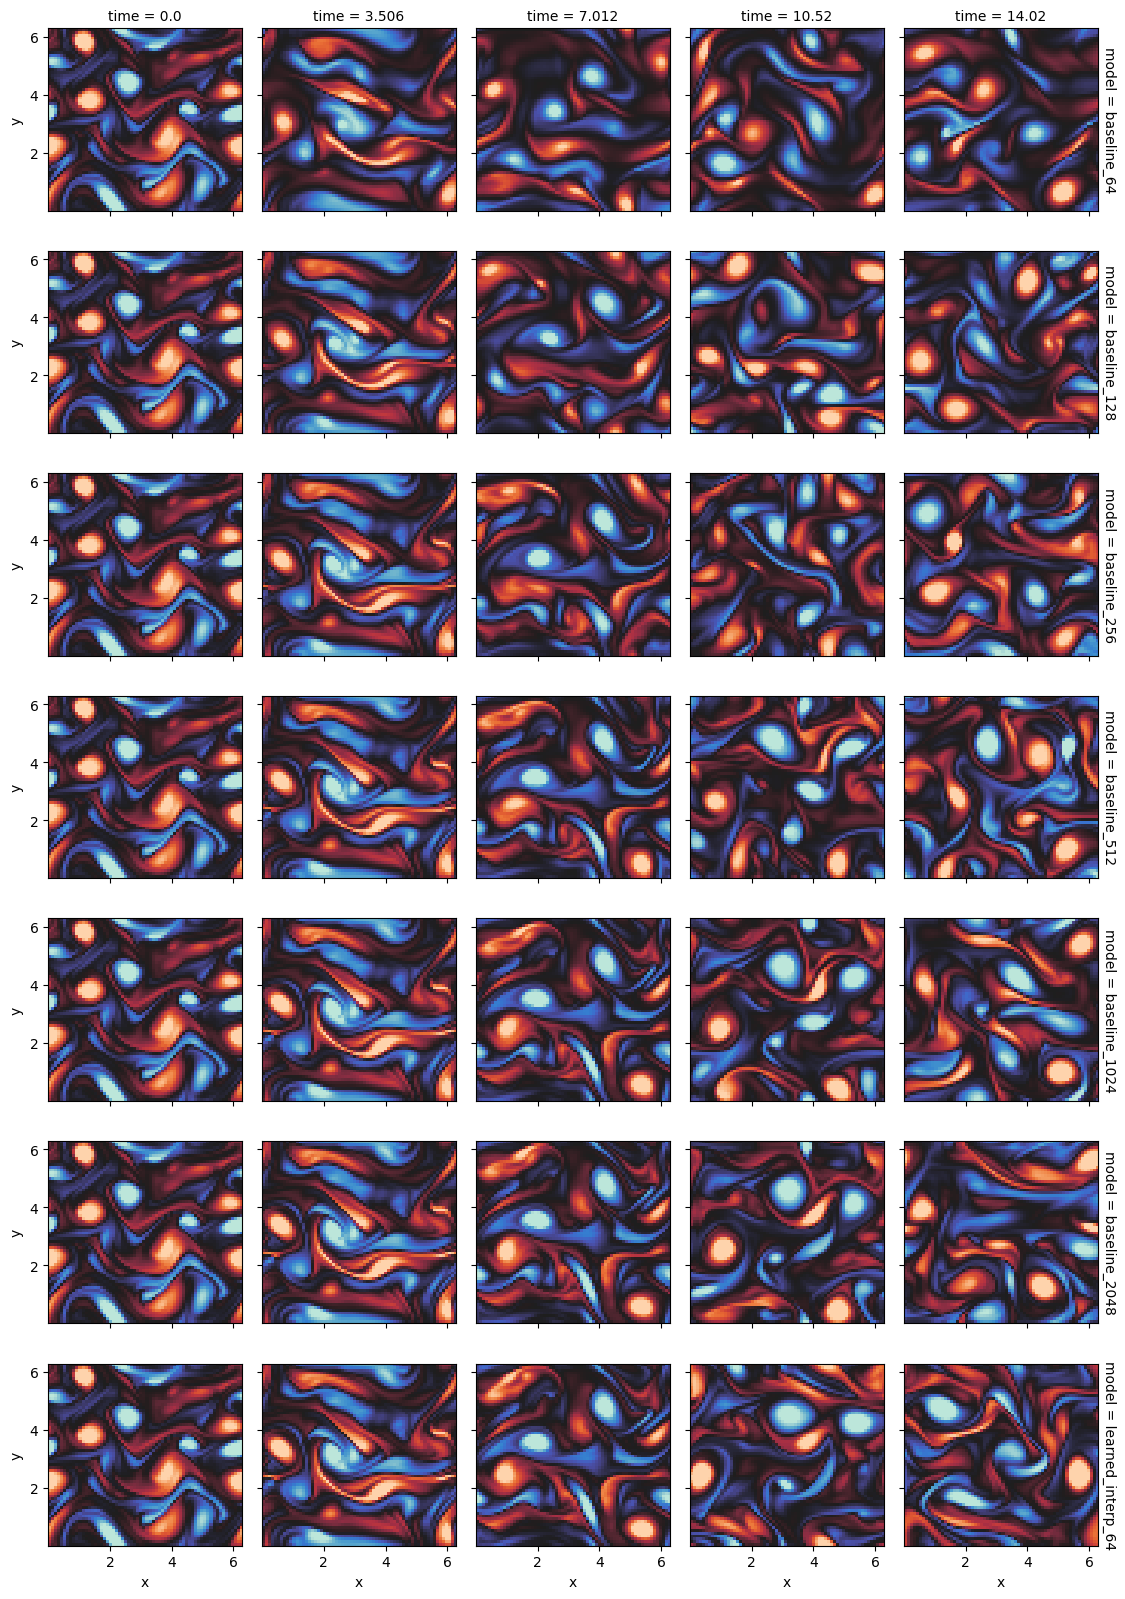

In [9]:
combined.vorticity.isel(sample=0).thin(time=50).head(time=5).plot.imshow(
    row='model', col='time', x='x', y='y', robust=True, size=2.3, aspect=0.9,
    add_colorbar=False, cmap=seaborn.cm.icefire, vmin=-10, vmax=10)

Look at baseline data for all samples

In [ ]:
combined.vorticity.sel(model='baseline_2048').thin(time=50).head(time=5).plot.imshow(
    row='sample', col='time', x='x', y='y', robust=True, size=2.3, aspect=0.9,
    add_colorbar=False, cmap=seaborn.cm.icefire, vmin=-10, vmax=10)

# Data for NN

In [84]:
modx = combined_32.where((combined_fig1.model =="baseline_1024") & (combined_32.sample==0),drop=True)
modx2= combined_32.where((combined_fig1.model =="baseline_1024") & (combined_32.sample==3)& (combined_32.time<75),drop=True)
modx3= combined_32.where((combined_fig1.model =="baseline_1024") & (combined_32.sample==6)& (combined_32.time<75),drop=True)

mody = combined_32.where((combined_fig1.model =="baseline_2048") & (combined_32.sample==0),drop=True)
testx = combined_32.where((combined_fig1.model =="baseline_512") & (combined_32.sample==0),drop=True)
testx4 = combined_32.where((combined_fig1.model =="baseline_1024") & (combined_32.sample==5),drop=True)

In [85]:
#x1 = modx["vorticity"].to_dataframe()
#x2 = modx2["vorticity"].to_dataframe()
#x3 = modx3["vorticity"].to_dataframe()

#X_train = pd.concat([x1, x2, x3])
#X_train=X_train.unstack(('x','y'))

In [86]:
X_train = modx["vorticity"].to_dataframe()
y_train = mody["vorticity"].to_dataframe()
X_test_df = testx["vorticity"].to_dataframe()

X_train.astype('float32')
y_train.astype('float32')
X_test_df.astype('float32')

y_train=y_train.unstack(('x','y'))
X_train=X_train.unstack(('x','y'))
X_test_df=X_test_df.unstack(('x','y'))

In [87]:
# Standardization
mean, std = X_train.mean(), X_train.std()

X_train   = (X_train - mean)/std
X_test_df = (X_test_df - mean)/std

X_train

vorticity                                \
x                                0.147262                                 
y                                0.147262  0.343612  0.539961  0.736311   
model         sample time                                                 
baseline_1024 0      0.000000    1.218228  1.183264  1.248557  1.440607   
                     0.070125    1.175806  1.144300  1.219417  1.422943   
                     0.140250    1.138573  1.113687  1.200408  1.399618   
                     0.210375    1.107747  1.092053  1.193225  1.368135   
                     0.280499    1.085084  1.080335  1.198986  1.322862   
...                                   ...       ...       ...       ...   
                     243.473431  0.289110  0.311208 -0.252570 -0.787413   
                     243.543555  0.445493  0.218922 -0.350557 -0.859023   
                     243.613680  0.510884  0.243137 -0.404226 -0.967960   
                     243.683805  0.514214  0.251461 -0.396034 -0.958988   
                     243.753930  0.505180  0.261269 -0.331953 -0.738807   

                                                                         \
x                                                                         
y                                0.932660  1.129010  1.325359  1.521709   
model         sample time                                                 
baseline_1024 0      0.000000    0.611133 -0.652091 -0.040882  0.069804   
                     0.070125    0.545889 -0.569289  0.002452  0.200979   
                     0.140250    0.454687 -0.475980  0.002800  0.370885   
                     0.210375    0.343157 -0.377544 -0.001506  0.543372   
                     0.280499    0.217050 -0.285178  0.012182  0.648491   
...                                   ...       ...       ...       ...   
                     243.473431 -0.900399 -0.107594  0.337184  0.660344   
                     243.543555 -1.049236 -0.590795  0.315686  0.519601   
                     243.613680 -1.271323 -0.918879 -0.081353  0.460162   
                     243.683805 -1.314786 -1.260023 -0.518358  0.356311   
                     243.753930 -1.062086 -1.366874 -1.003307  0.023693   

                                                     ...                      \
x                                                    ...  6.234098             
y                                1.718059  1.914408  ...  4.466952  4.663302   
model         sample time                            ...                       
baseline_1024 0      0.000000    1.616262  2.125099  ...  0.221038  0.077002   
                     0.070125    1.588614  2.081180  ...  0.308314 -0.047951   
                     0.140250    1.521426  2.054748  ...  0.350067 -0.215799   
                     0.210375    1.423208  2.045331  ...  0.326430 -0.426700   
                     0.280499    1.320892  2.046329  ...  0.153387 -0.617710   
...                                   ...       ...  ...       ...       ...   
                     243.473431  0.236010 -0.724859  ... -0.743135 -0.574170   
                     243.543555  0.265973 -0.663446  ... -0.765138 -0.741477   
                     243.613680  0.279960 -0.586835  ... -0.786885 -0.863100   
                     243.683805  0.255658 -0.501585  ... -0.843019 -0.904160   
                     243.753930  0.217326 -0.416634  ... -0.935614 -0.873504   

                                                                         \
x                                                                         
y                                4.859651  5.056001  5.252350  5.448700   
model         sample time                                                 
baseline_1024 0      0.000000   -0.128508 -2.061927 -2.340661 -0.572888   
                     0.070125   -0.196463 -1.574749 -2.488046 -0.680314   
                     0.140250   -0.365994 -1.064376 -2.503032 -0.833058   
                     0.210375   -0.570840 -0.697999 -2

In [88]:
X_test = X_test_df.to_numpy()
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [45]:
print(X_train.shape,y_train.shape,X_test.shape)

(3210, 1024) (3210, 1024) (714, 1024)


In [46]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# set hyperparameters
n_neuron       = 32
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [81]:
model = Sequential()

model.add(Dense(X_train.shape[1],  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
model.add(Dense(y_train.shape[1],  activation='linear')) # the output layer

model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [82]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_14 (Dense)            (None, 32)                32800     
                                                                 
 dense_15 (Dense)            (None, 32)                1056      
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
Total params: 1,084,512
Trainable params: 1,084,512
Non-trainable params: 0
_________________________________________________________________


In [83]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.05, 
                    verbose         = 1,
                    callbacks       = [early_stop]
                   )

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/mean_squared_error/BroadcastGradientArgs' defined at (most recent call last):
    File "C:\Users\William\anaconda3\envs\jax-env\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\William\anaconda3\envs\jax-env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\William\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\William\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\William\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\William\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\William\anaconda3\envs\jax-env\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\William\anaconda3\envs\jax-env\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\William\anaconda3\envs\jax-env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\William\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\William\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\William\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\William\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\William\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\William\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\William\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\William\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\William\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\William\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\William\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\William\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\William\AppData\Local\Temp\ipykernel_1744\2074421394.py", line 4, in <module>
      history = model.fit(X_train, y_train,
    File "C:\Users\William\anaconda3\envs\jax-env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\William\anaconda3\envs\jax-env\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\William\anaconda3\envs\jax-env\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\William\anaconda3\envs\jax-env\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\William\anaconda3\envs\jax-env\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\William\anaconda3\envs\jax-env\lib\site-packages\keras\engine\training.py", line 893, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\William\anaconda3\envs\jax-env\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 537, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\William\anaconda3\envs\jax-env\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 590, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "C:\Users\William\anaconda3\envs\jax-env\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 471, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/mean_squared_error/BroadcastGradientArgs'
Incompatible shapes: [64,32] vs. [64,32,32]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_20524]

(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>)

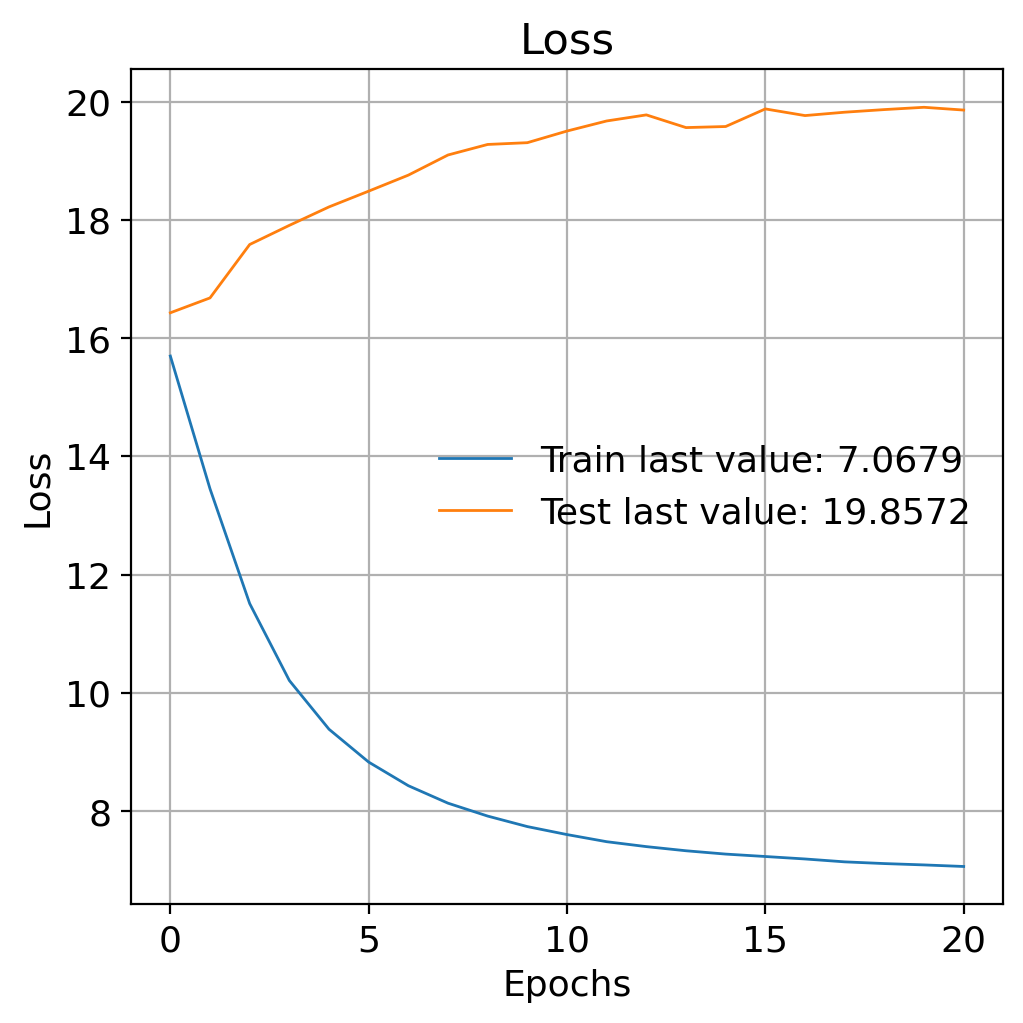

In [243]:
from plot_keras_history import show_history, plot_history
plot_history(history)

In [31]:
model_path = os.path.join(cwd,'saved_model_proj')
#os.mkdir(model_path)

In [51]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'NN_model.h5'))

In [52]:
# reload the saved model
model = load_model(os.path.join(model_path,'NN_model.h5'))

In [53]:
y_test_pre = model.predict(X_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 32, 32)
y_test_pre = xr.Dataset(coords={
                                
                               'time': testx.time.values, 
                               'x': testx.x.values, 
                               'y': testx.y.values,
                               'sample':0,
                                'model':'Prediction'
                               },

                        
                       data_vars=dict(vorticity=(['time', 'x', 'y'], y_test_pre)))
y_test_pre=y_test_pre.expand_dims(sample=1,model=1)

23/23 [==============================] - 0s 4ms/step


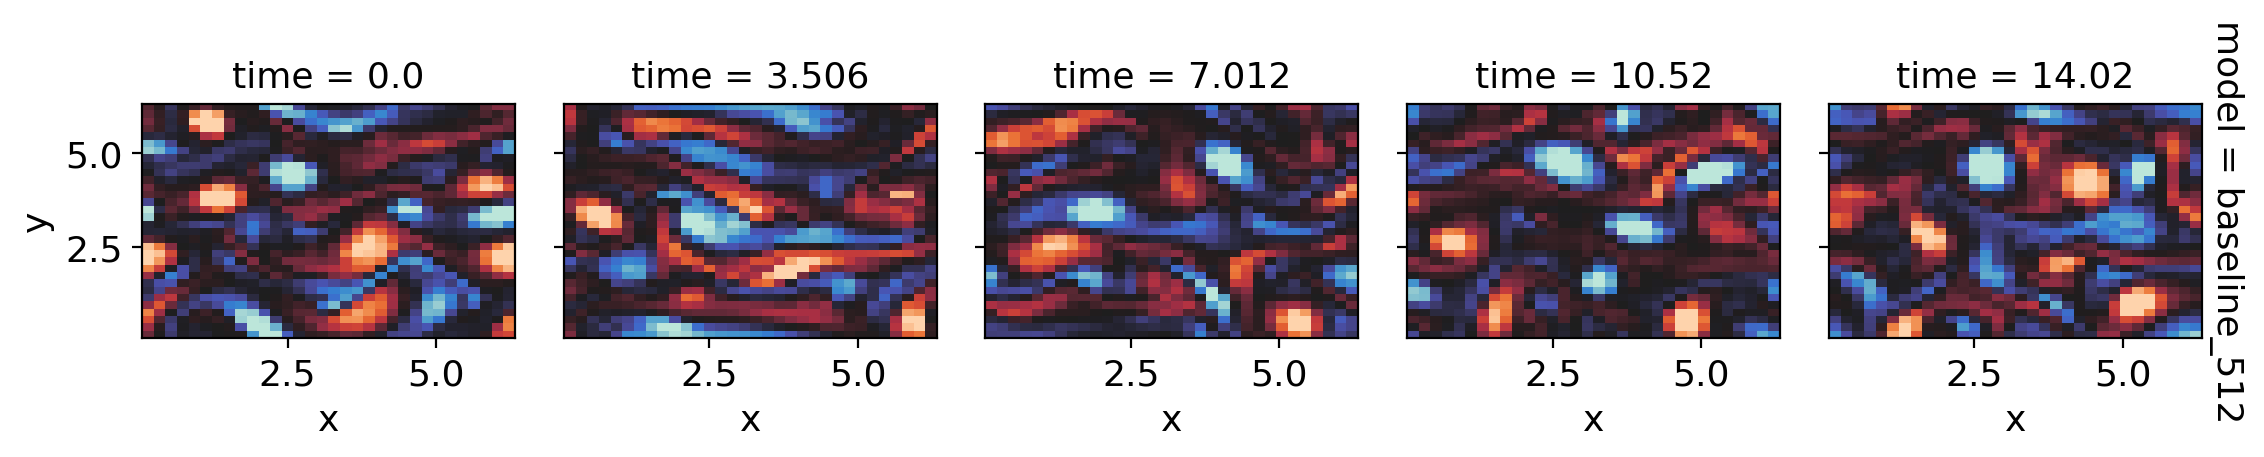

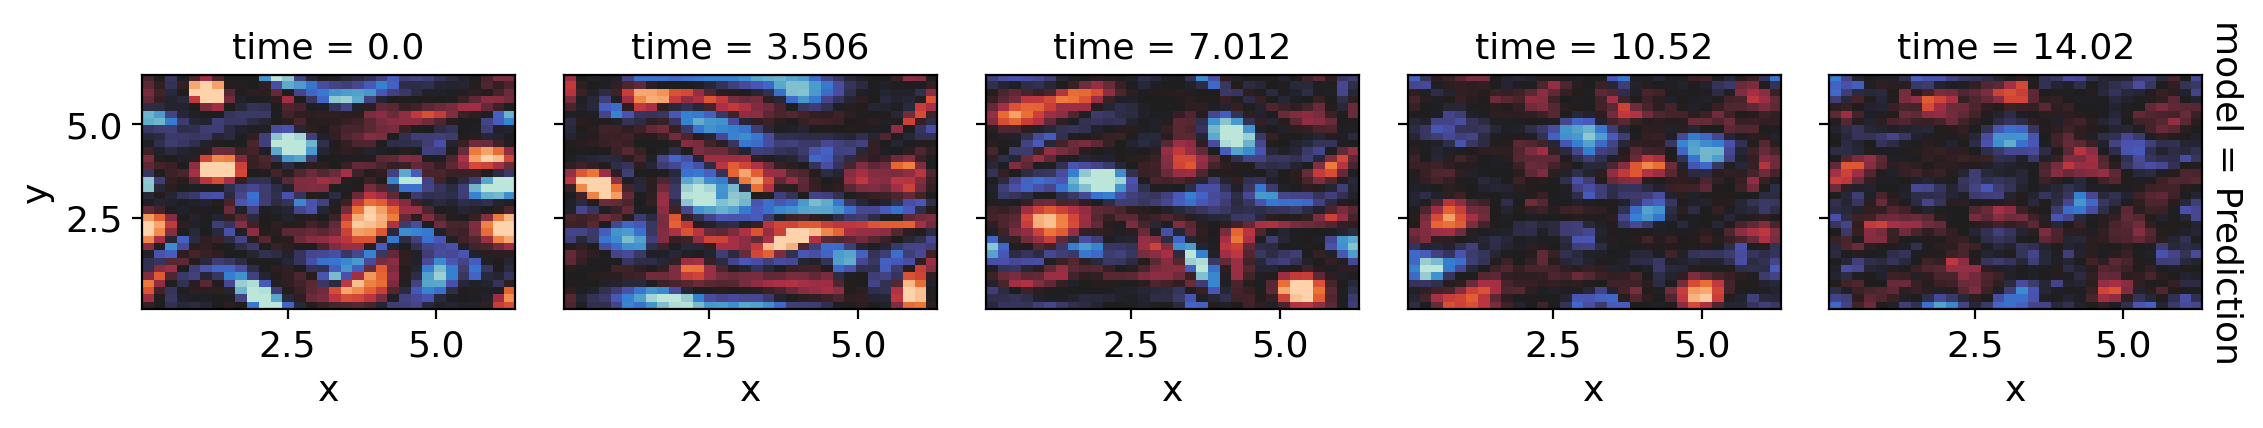

In [80]:
testx.vorticity.isel(sample=0).thin(time=50).head(time=5).plot.imshow(
    row='model', col='time', x='x', y='y', robust=True, size=2.3, aspect=0.9,
    add_colorbar=False, cmap=seaborn.cm.icefire, vmin=-10, vmax=10)
y_test_pre.vorticity.isel(sample=0).thin(time=50).head(time=5).plot.imshow(
    row='model', col='time', x='x', y='y', robust=True, size=2.3, aspect=0.9,
    add_colorbar=False, cmap=seaborn.cm.icefire, vmin=-10, vmax=10)

# LSTM

In [89]:
X_length=500
start = 0 #np.cumsum(X_length) - X_length
end   = 100 #np.cumsum(X_length)

slider = 50
X_train_all = []
y_train_all = []

for i in range(X_length):
    
    X_subset = X_train[start:end,:]
    y_subset = y_train[start:end,:]
    
    X_subset = np.array([X_subset[i:i+slider] for i in range(0, X_subset.shape[0]-slider+1)])
    y_subset = np.array([[y_subset[i+slider-1]] for i in range(0, y_subset.shape[0]-slider+1)])
    
    X_train_all.append(X_subset)
    y_train_all.append(y_subset)
    
X_train = np.concatenate(X_train_all,axis=0)
y_train = np.concatenate(y_train_all,axis=0)
X_test  = np.array([X_test[i:i+slider] for i in range(0, X_test.shape[0]-slider+1)])
print(X_train.shape,y_train.shape,X_test.shape)

(25500, 50, 1024) (25500, 1, 1024) (3428, 50, 1024)


In [90]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 10
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [91]:
X_train.shape

(25500, 50, 1024)

In [92]:
lstm_model = Sequential()
lstm_model.add(LSTM(n_neuron,input_shape=(X_train.shape[1],X_train.shape[2]),
               return_sequences=True,activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(y_train.shape[-1],activation='linear')) 

lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 64)            278784    
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 1024)              66560     
                                                                 
Total params: 382,528
Trainable params: 382,528
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = lstm_model.fit(X_train, y_train, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>)

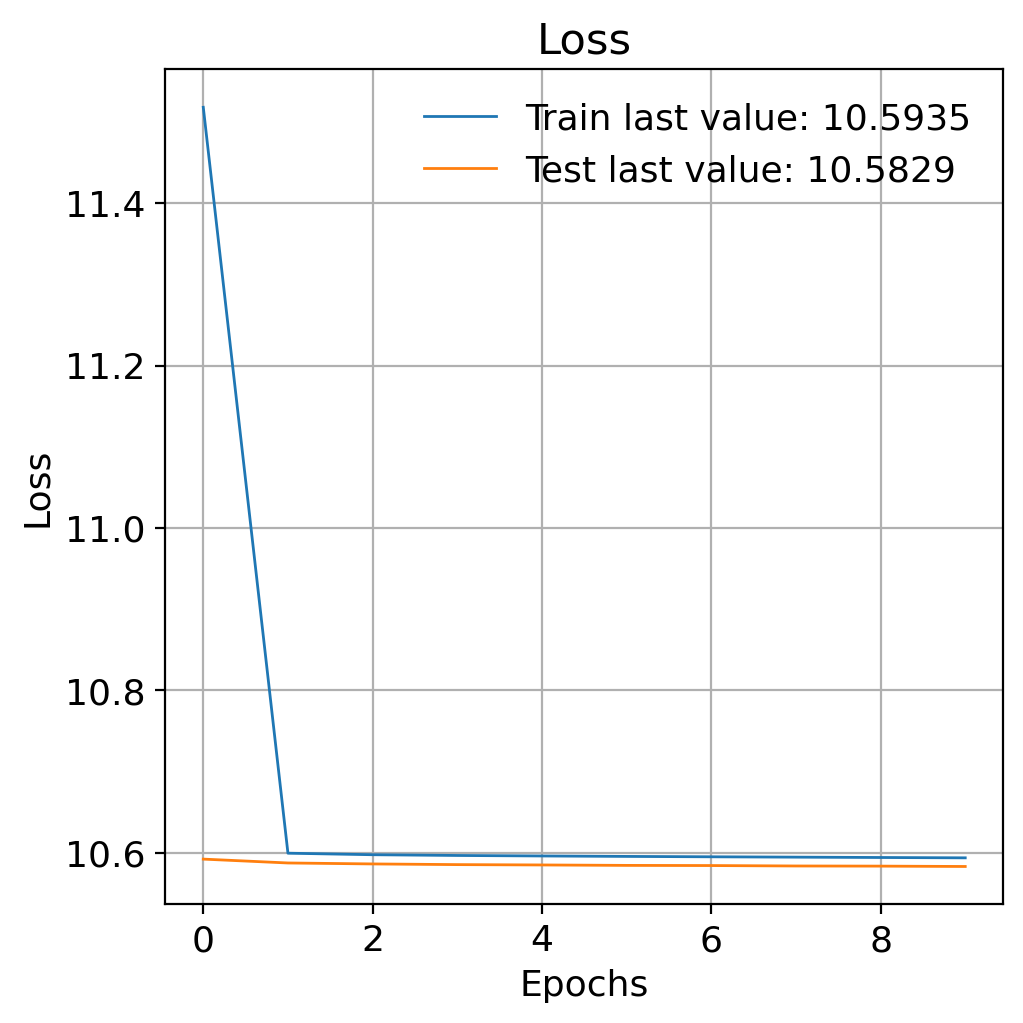

In [28]:
from plot_keras_history import show_history, plot_history
plot_history(history)

In [32]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
lstm_model.save(os.path.join(model_path,'LSTM_model.h5'))

In [33]:
# reload the saved model
lstm_model = load_model(os.path.join(model_path,'LSTM_model.h5'))

In [34]:
y_test_pre = lstm_model.predict(X_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0],  32, 32)

y_test_pre = xr.Dataset(coords={'time': testx.time.values[slider-1:], 
                               'x': testx.x.values, 
                               'y': testx.y.values,
                               'sample':0,
                                'model':'baseline_1'},
                        
                       data_vars=dict(vorticity=(['time', 'x', 'y'], y_test_pre)))
y_test_pre=y_test_pre.expand_dims(sample=1,model=1)

22/22 [==============================] - 2s 82ms/step


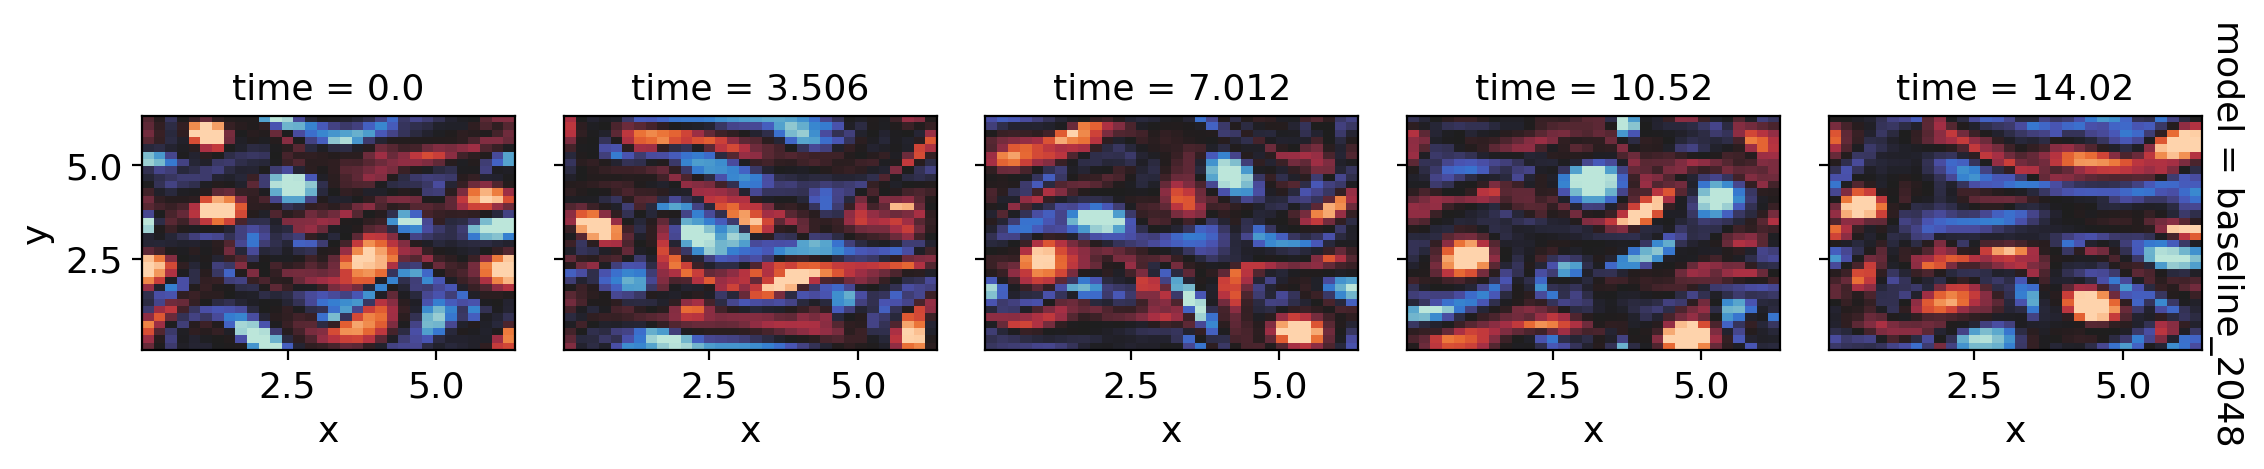

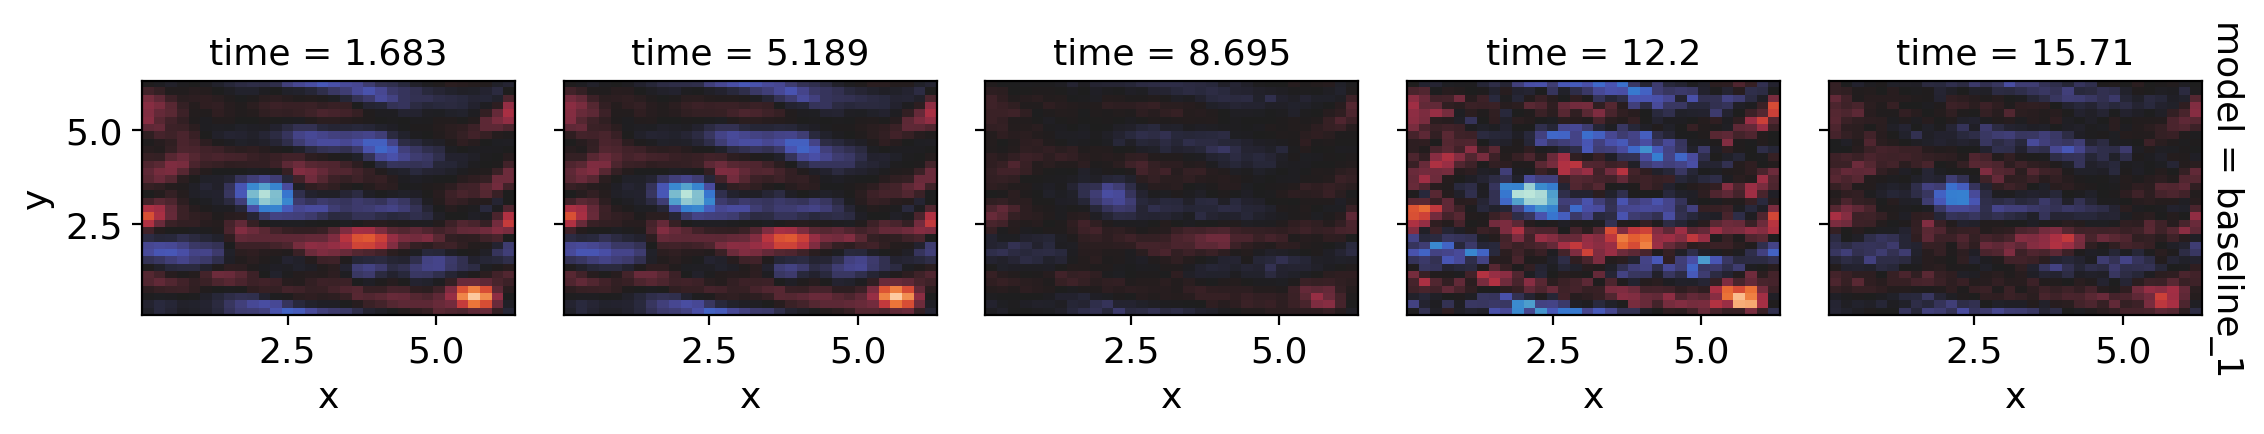

In [35]:
mody.vorticity.isel(sample=0).thin(time=50).head(time=5).plot.imshow(
    row='model', col='time', x='x', y='y', robust=True, size=2.3, aspect=0.9,
    add_colorbar=False, cmap=seaborn.cm.icefire, vmin=-10, vmax=10)
y_test_pre.vorticity.isel(sample=0).thin(time=50).head(time=5).plot.imshow(
    row='model', col='time', x='x', y='y', robust=True, size=2.3, aspect=0.9,
    add_colorbar=False, cmap=seaborn.cm.icefire, vmin=-10, vmax=10)

# Rearrange data for CNN

In [60]:
X_train = modx["vorticity"].to_dataframe()
X_train=X_train.unstack(('x','y'))
X_train = X_train.to_numpy()

y_train = mody["vorticity"].to_numpy()
y_train=y_train[0,0,:,:,:]


In [77]:
X_test_df = testx["vorticity"].to_dataframe()
X_test_df=X_test_df.unstack(('x','y'))
X_test_df = X_test_df.to_numpy()
X_test=X_test_df

In [62]:
np.shape(X_test)

(714, 1024)

In [63]:
n_filters  = 32  # number of filters
n_neurons  = 32  # number of neurons in the Dense layer
activation     = 'relu' # activation function
kernel_size    = 4
learning_rate  = 0.001
minibatch_size = 64
num_epochs     = 10

In [64]:
from tensorflow.keras import datasets, layers, models

model = Sequential()

model.add(Dense(n_filters*32*32, input_shape=(X_train.shape[1],), activation=activation)) # shape: (32768,1)
model.add(Reshape((32,32,n_filters))) # shape: (32,32,32)

#model.add(layers.Conv2D(n_filters, (32, 32), activation=activation, input_shape=(32, 32)))
#model.add(layers.MaxPooling2D((2, 2)))

#model.add(layers.Conv2D(n_filters, (16, 16), activation=activation, input_shape=(32, 32)))
#model.add(layers.MaxPooling2D((2, 2)))
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, padding='same')) # shape: (96,144,32)

model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, padding='same')) # shape: (96,144,32)

model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, padding='same')) # shape: (96,144,32)

model.add(Conv2DTranspose(filters=1, kernel_size=kernel_size, activation="linear", padding="same")) # shape: (96,144,1)


model.summary()
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32768)             33587200  
                                                                 
 reshape (Reshape)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 32)       16416     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 32)       16416     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       16416     
 ranspose)                                                       
                                                      

In [65]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/10
44/44 [==============================] - 15s 337ms/step - loss: 7.0597 - val_loss: 18.5810
Epoch 2/10
44/44 [==============================] - 15s 347ms/step - loss: 1.6051 - val_loss: 18.6791
Epoch 3/10
44/44 [==============================] - 15s 344ms/step - loss: 0.9013 - val_loss: 18.5550
Epoch 4/10
44/44 [==============================] - 15s 336ms/step - loss: 0.6620 - val_loss: 18.6651
Epoch 5/10
44/44 [==============================] - 15s 338ms/step - loss: 0.4936 - val_loss: 18.6895
Epoch 6/10
44/44 [==============================] - 15s 341ms/step - loss: 0.4065 - val_loss: 18.7917
Epoch 7/10
44/44 [==============================] - 15s 333ms/step - loss: 0.3640 - val_loss: 18.7403
Epoch 8/10
44/44 [==============================] - 15s 346ms/step - loss: 0.3409 - val_loss: 18.7658
Epoch 9/10
44/44 [==============================] - 15s 342ms/step - loss: 0.3010 - val_loss: 18.7264
Epoch 10/10
44/44 [==============================] - 15s 341ms/step - loss: 0.2759

(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>)

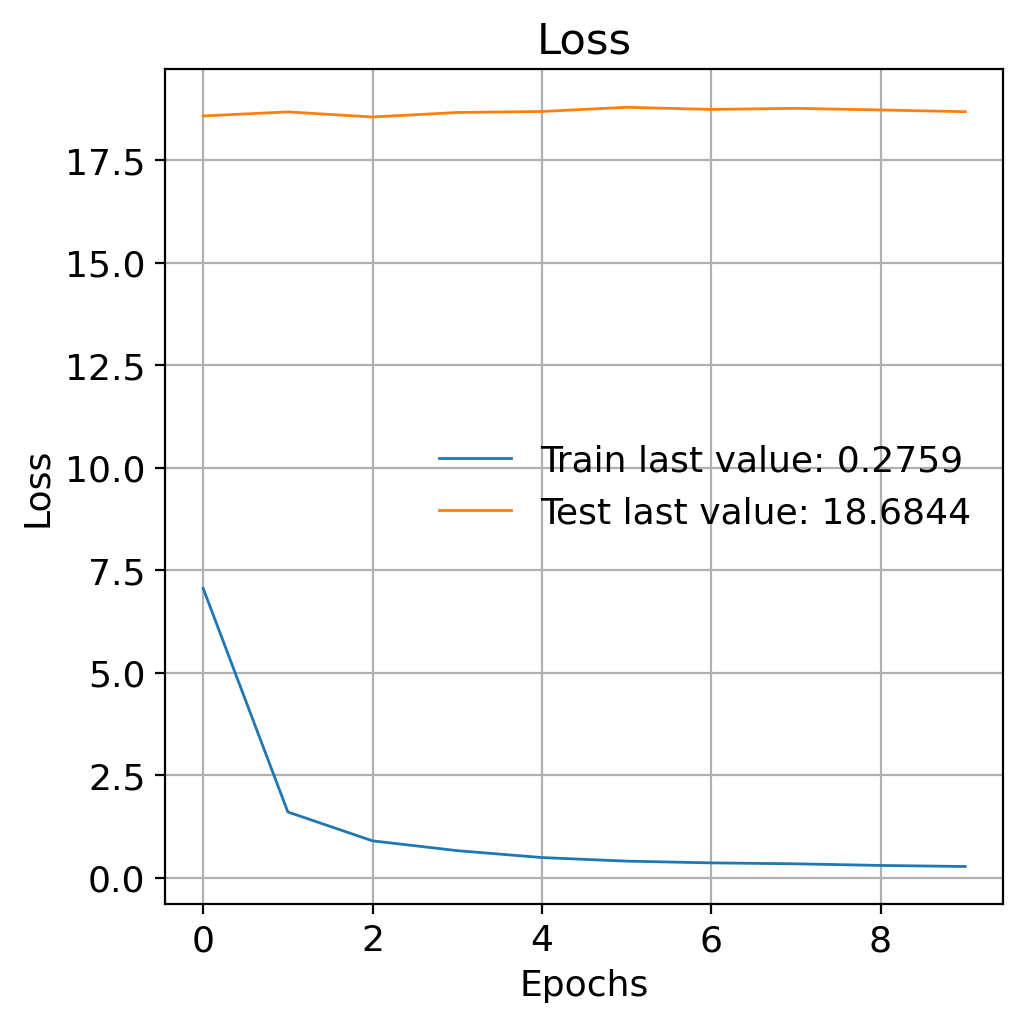

In [66]:
plot_history(history)

In [67]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'CNN_model.h5'))

In [68]:
# reload the saved model
model = load_model(os.path.join(model_path,'CNN_model.h5'))

In [78]:
y_test_pre = model.predict(X_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 32, 32)

y_test_pre = xr.Dataset(coords={'time': testx.time.values, 
                               'x': testx.x.values, 
                               'y': testx.y.values,
                                'sample':0,
                                'model':'Prediction'},
                       data_vars=dict(vorticity=(['time', 'x', 'y'], y_test_pre)))
y_test_pre=y_test_pre.expand_dims(sample=1,model=1)

109/109 [==============================] - 5s 50ms/step


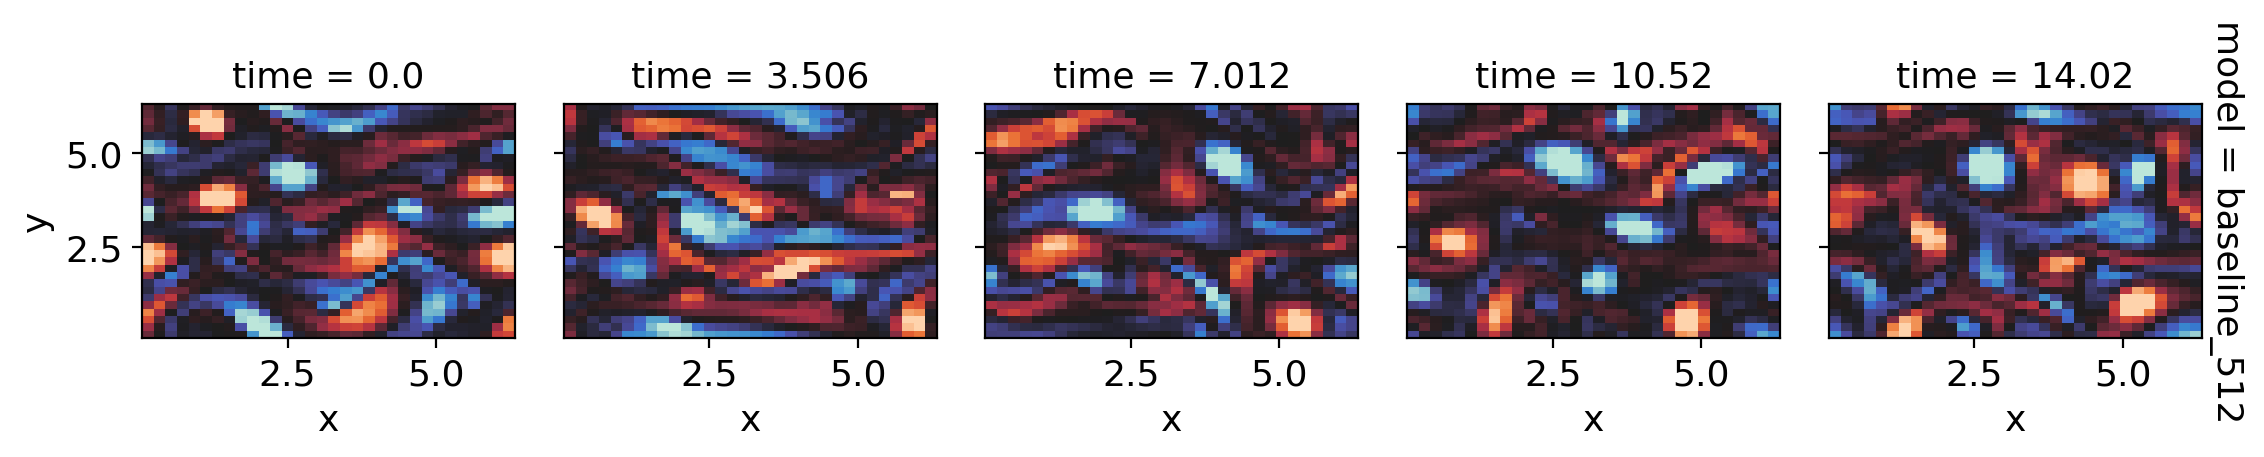

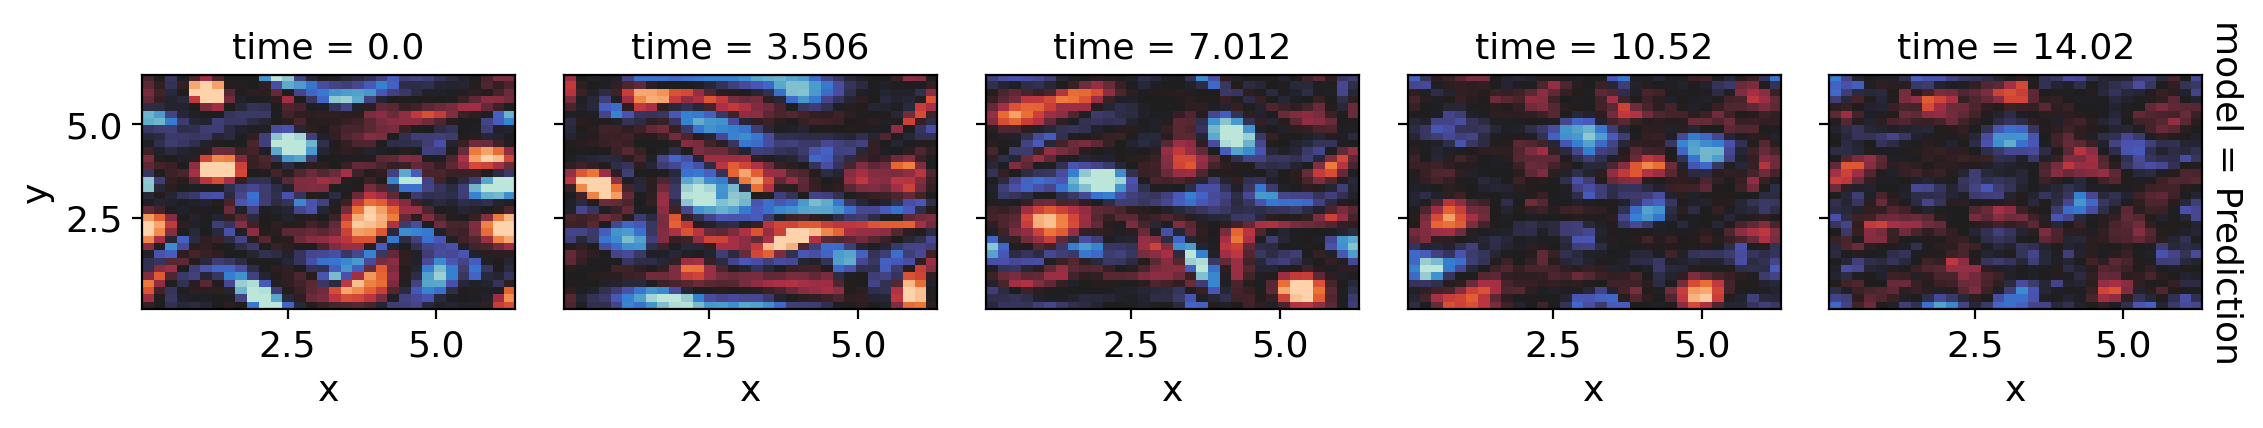

In [79]:
testx.vorticity.isel(sample=0).thin(time=50).head(time=5).plot.imshow(
    row='model', col='time', x='x', y='y', robust=True, size=2.3, aspect=0.9,
    add_colorbar=False, cmap=seaborn.cm.icefire, vmin=-10, vmax=10)
y_test_pre.vorticity.isel(sample=0).thin(time=50).head(time=5).plot.imshow(
    row='model', col='time', x='x', y='y', robust=True, size=2.3, aspect=0.9,
    add_colorbar=False, cmap=seaborn.cm.icefire, vmin=-10, vmax=10)

# Generalization Test

In [149]:
X_test_df = testx4["vorticity"].to_dataframe()
X_test_df=X_test_df.unstack(('x','y'))
X_test_df = X_test_df.to_numpy()
X_test=X_test_df

<xarray.Dataset>
Dimensions:    (model: 1, sample: 1, time: 3477, x: 32, y: 32)
Coordinates:
  * time       (time) float64 0.0 0.07012 0.1402 0.2104 ... 243.6 243.7 243.8
  * x          (x) float64 0.1473 0.3436 0.54 0.7363 ... 5.645 5.841 6.038 6.234
  * y          (y) float64 0.1473 0.3436 0.54 0.7363 ... 5.645 5.841 6.038 6.234
  * sample     (sample) int32 0
  * model      (model) <U18 'baseline_2048'
Data variables:
    u          (model, sample, time, x, y) float32 dask.array<chunksize=(1, 1, 381, 32, 32), meta=np.ndarray>
    v          (model, sample, time, x, y) float32 dask.array<chunksize=(1, 1, 381, 32, 32), meta=np.ndarray>
    vorticity  (model, sample, time, x, y) float64 dask.array<chunksize=(1, 1, 381, 32, 32), meta=np.ndarray>
Attributes: (12/17)
    domain_size:                   [0.         6.28318531]
    domain_size_multiple:          1
    full_config_str:               \n# Macros:\n# ===========================...
    init_cfl_safety_factor:        0.5
    init_peak_wavenumber:          4.0
    maximum_velocity:              7.0
    ...                            ...
    simulation_time:               240.0
    stable_time_step:              0.007012483601762931
    time_subsample_factor:         1
    tracing_max_duration_in_msec:  100.0
    warmup_grid_size:              2048
    warmup_time:                   40.0

In [196]:
y_test_pre = model.predict(X_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 32, 32)

y_test_pre = xr.Dataset(coords={'time': testx4.time.values, 
                               'x': testx4.x.values, 
                               'y': testx4.y.values,
                                'sample':0,
                                'model':'Prediction'},
                       data_vars=dict(vorticity=(['time', 'x', 'y'], y_test_pre)))
y_test_pre=y_test_pre.expand_dims(sample=1,model=1)

109/109 [==============================] - 0s 2ms/step


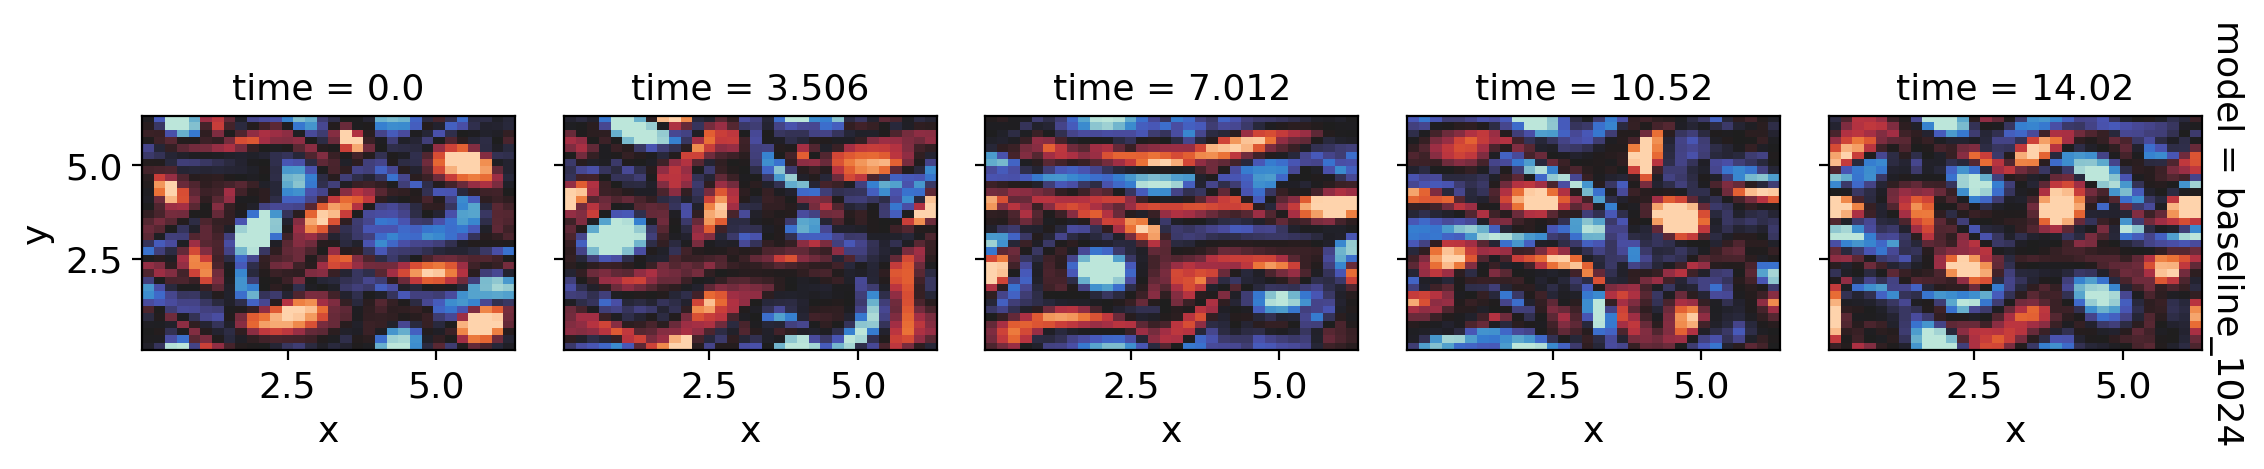

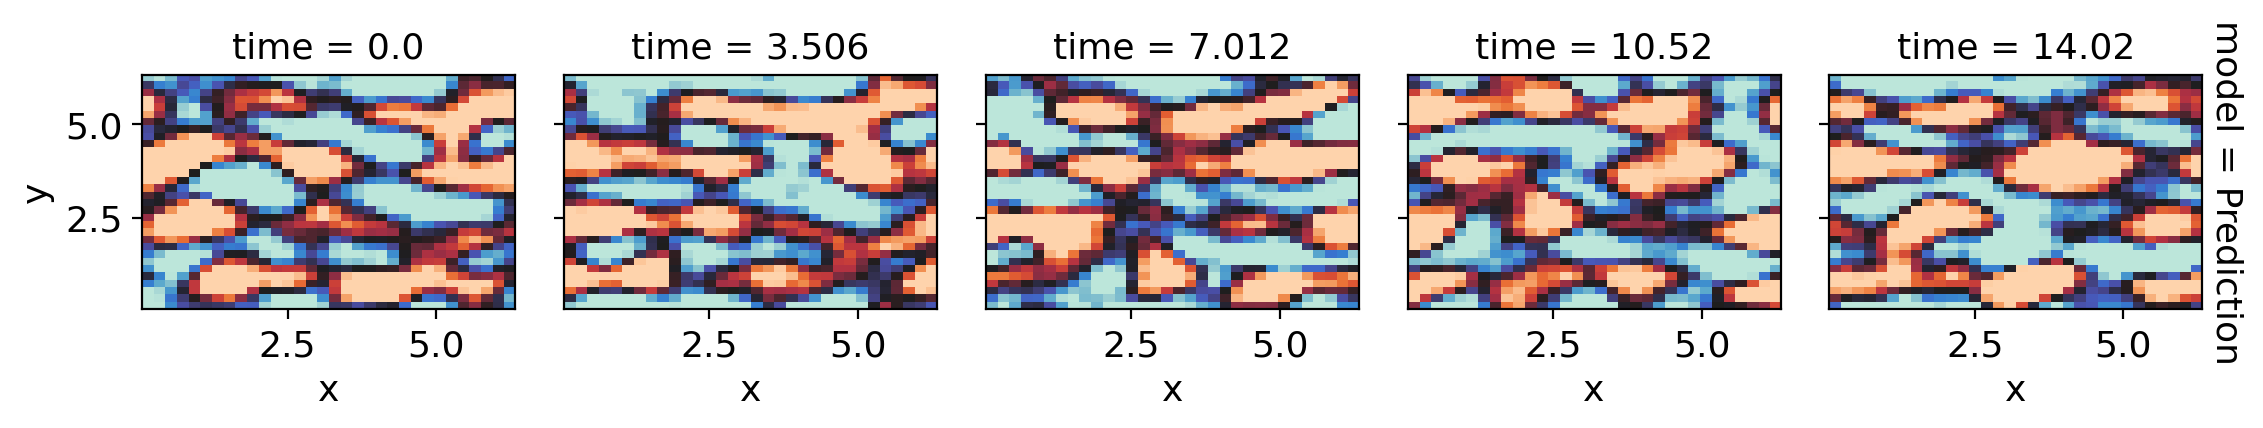

In [198]:
testx4.vorticity.isel(sample=0).thin(time=50).head(time=5).plot.imshow(
    row='model', col='time', x='x', y='y', robust=True, size=2.3, aspect=0.9,
    add_colorbar=False, cmap=seaborn.cm.icefire, vmin=-10, vmax=10)
y_test_pre.vorticity.isel(sample=0).thin(time=50).head(time=5).plot.imshow(
    row='model', col='time', x='x', y='y', robust=True, size=2.3, aspect=0.9,
    add_colorbar=False, cmap=seaborn.cm.icefire, vmin=-10, vmax=10)